# 🤒 Epidemic mitigation project (Riccardo Brioschi, Francesca Venturi)

This notebook contains the execution code of the *epidemic mitigation process* carried out by Riccardo Brioschi and Francesca Venturi. 

Moreover, not only does it contain the code, it also includes comments and discussions about results, coherently with the requirements of the project.

## Importing useful packages and Initializing the model class

In [50]:
# Importing useful library
import matplotlib.pyplot as plt
from gym import spaces
from helper import *

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch

from os import makedirs
from shutil import rmtree

import warnings
warnings.filterwarnings('ignore')

# If gpu is to be used
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(42)
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

## Question 1

### Initializing the environment needed to answer question in part 1. 

To be coherent with the structure of the tutorial, we decide to encode the actions as integer numbers (that is what is required from the `action_space`) and to exploit the `action_preprocessor` to convert them as a dictionary. Notice that at this stage of the mini-project this is not strictly required, as everything should work equivalently without this change.

On the contrary, giving the `observation_reprocessor` as an input argument is essential to later plot and visualize the results.

In [3]:
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

Since the action we take is always the same (actually, we do not take any action, which means we select `ACTION_NULL`), we initialize it accordingly to the `action_space` and we use it when simulating the epidemic dynamics in our environment.

In [4]:
ACTION_NULL = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

In [5]:
log = []
seed = 1
finished = False
obs, info = env.reset(seed) # here it is not seeded
for t in range(30):
    obs, R, finished, info = env.step(ACTION_NULL) # always same actions
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

#### Plots

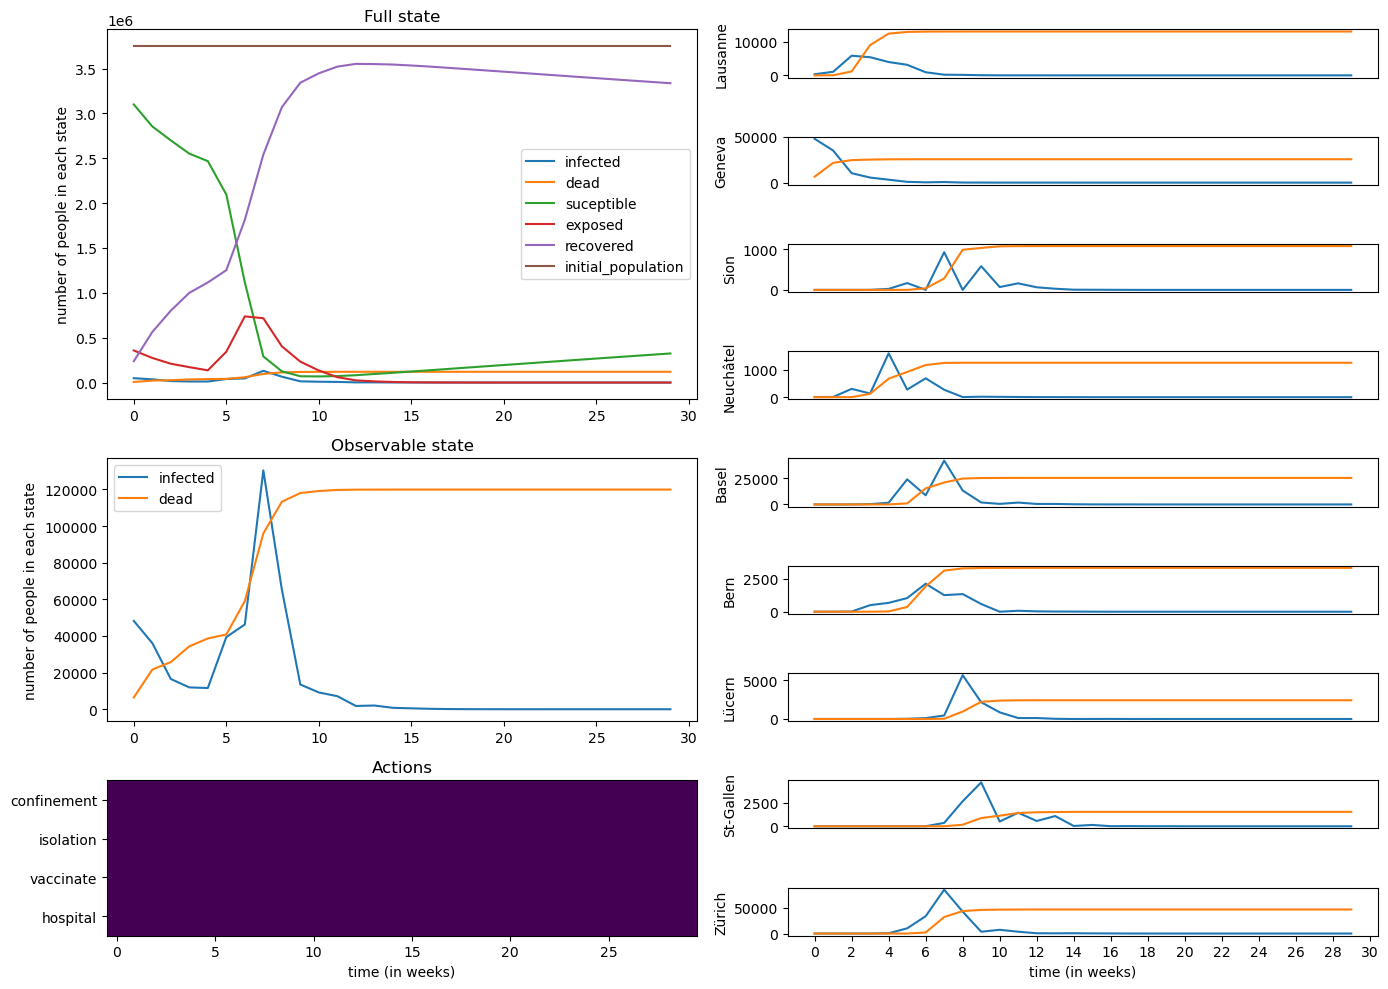

In [6]:
plot_info(total, cities, actions)

### DISCUSSION

## Question 2

### Question 2.a
We implement Pr. Russo’s Policy as a python class (subclass the Agent abstract class provided with the project files) and initialize the agent accordingly.

Pr. Russo's Policy consists in confining (`ACTION_CONFINE`) the popoluation for 4 weeks once the infected amount of people exceeds 20000 units. The *confinement action* is not debatable during the confinment. This means that the confinments happen in blocks of (at least) 4 weeks each.

In [7]:
class RussoAgent(Agent): # Agent is the superclass
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.count_remaining_weeks = 0
        self.default_action  = { # DO NOTHING
                                'confinement': False, 
                                'isolation': False, 
                                'hospital': False, 
                                'vaccinate': False,
                            }
        self.confinement_action = { # CONFINE
                                    'confinement': True, 
                                    'isolation': False, 
                                    'hospital': False, 
                                    'vaccinate': False,
                                }
        self.confinement_weeks_count = 0
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self, env):
        # This should be called when the environment is reset (we do not loss any weight, no need to 
        # redefine actions, the environment is new and we need to save it)
        self.env = env
        self.count_remaining_weeks = 0
        self.confinement_weeks_count = 0
    
    def act(self, info):
        # this takes an observation and returns an action
        if self.count_remaining_weeks == 0:
            total_infected = info.total.infected # number of infected people at end of week 4
            
            if total_infected > 20000:
                self.count_remaining_weeks = 4
                self.confinement_weeks_count += 1
                return self.confinement_action
            
            else:
                return self.default_action
                
        else:
            self.count_remaining_weeks -= 1
            self.confinement_weeks_count += 1
            return self.confinement_action
            
agent = RussoAgent(env)

We now run a simulation applying Pr. Russo's Policy.

In [8]:
""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed) # initialization (random infection)
agent.reset(env) # useless
agent.epsilon = 0 # taken from Agent, which is superclass
while not finished:
    action = agent.act(info)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

#### Plots

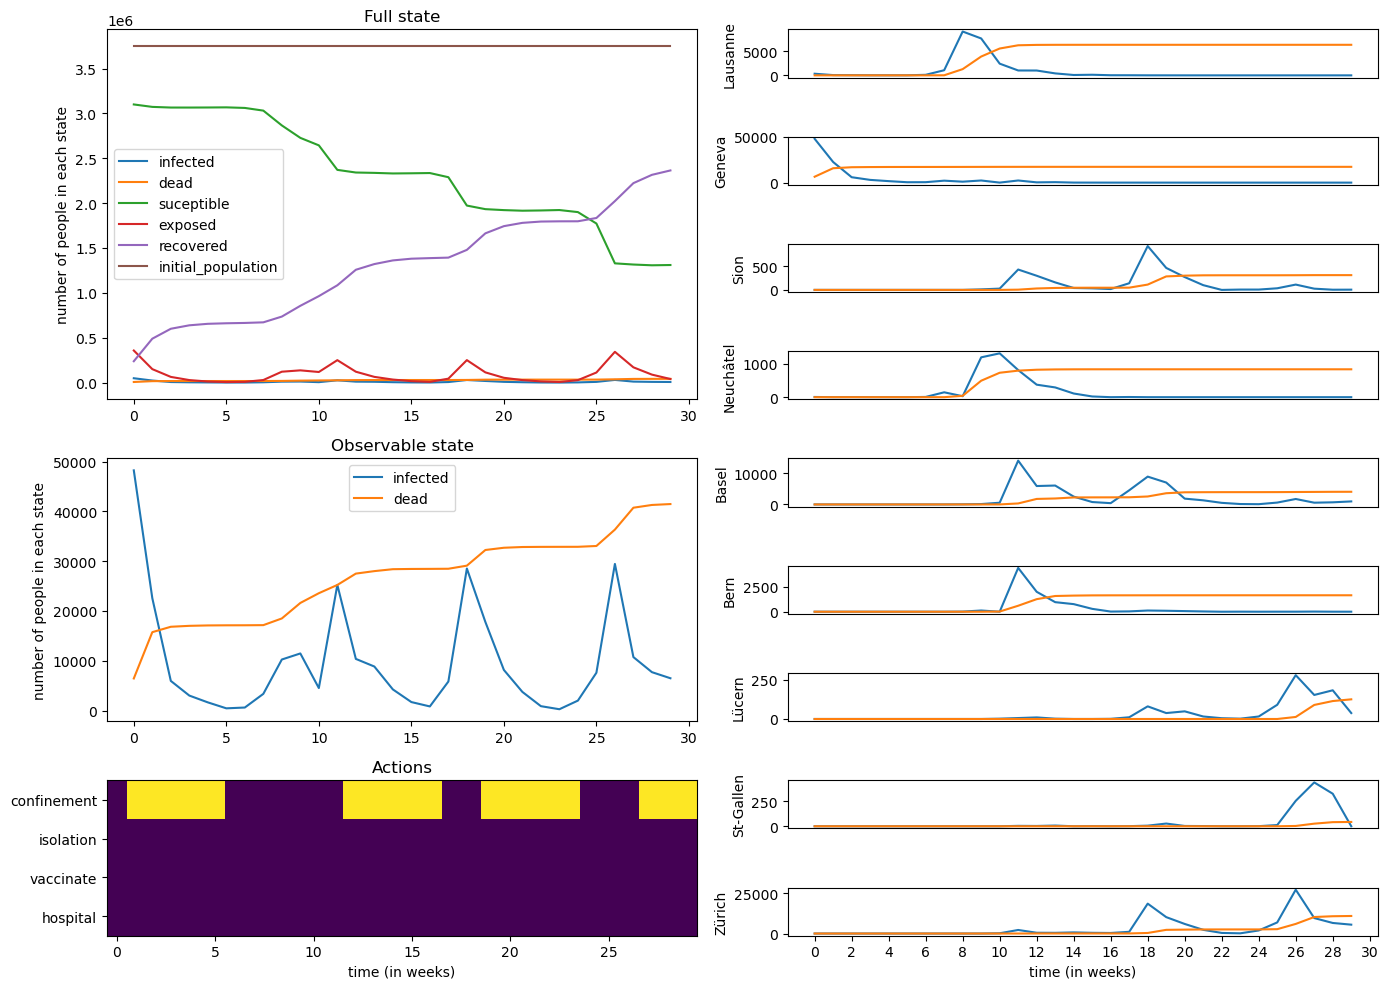

In [9]:
plot_info(total, cities, actions)

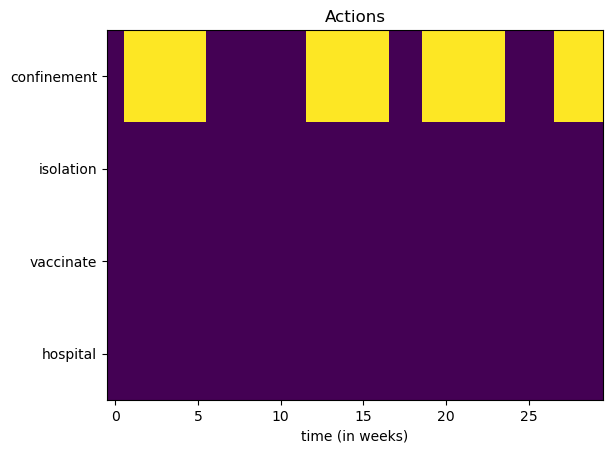

In [10]:
plt.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
plt.title('Actions')
plt.yticks([0,1,2,3], labels = list(actions.keys()))
plt.xlabel('time (in weeks)')
plt.show()

### Question 2.b

In order to be able to make meaningful conclusions, we implement the following evaluation procedure: we run 50 simulation episodes where actions are chosen from Pr. Russo's Policy.

Notice that, to make results reproducible, we initialize one seed for every episode in the simulation: the i-th simulation corresponds to `seed = i`

In [11]:
agent = RussoAgent(env)
seeds = range(1,51)

# Initializing useful variables
conf_days = []
rewards = []
deaths = []

# Looping over 50 episodes
for trace in range(50): # for loop over episodes
    R_cumulative = 0
    finished = False
    obs, info = env.reset(seeds[trace]) # resetting the environment
    agent.reset(env)
    
    # Looping over 30 weeks
    for t in range(30):
        action = agent.act(info)
        obs, R, finished, info = env.step(action) 
        R_cumulative+= R.item()
        if finished:
            break
    """ Parse the logs """
    # Saving total number of confined days
    conf_days.append(7 * agent.confinement_weeks_count)
    # R_cumulative is computed in the inner loop
    rewards.append(R_cumulative)
    # Number of total deaths in the current episode
    deaths.append(info.total.dead)

#### Plots

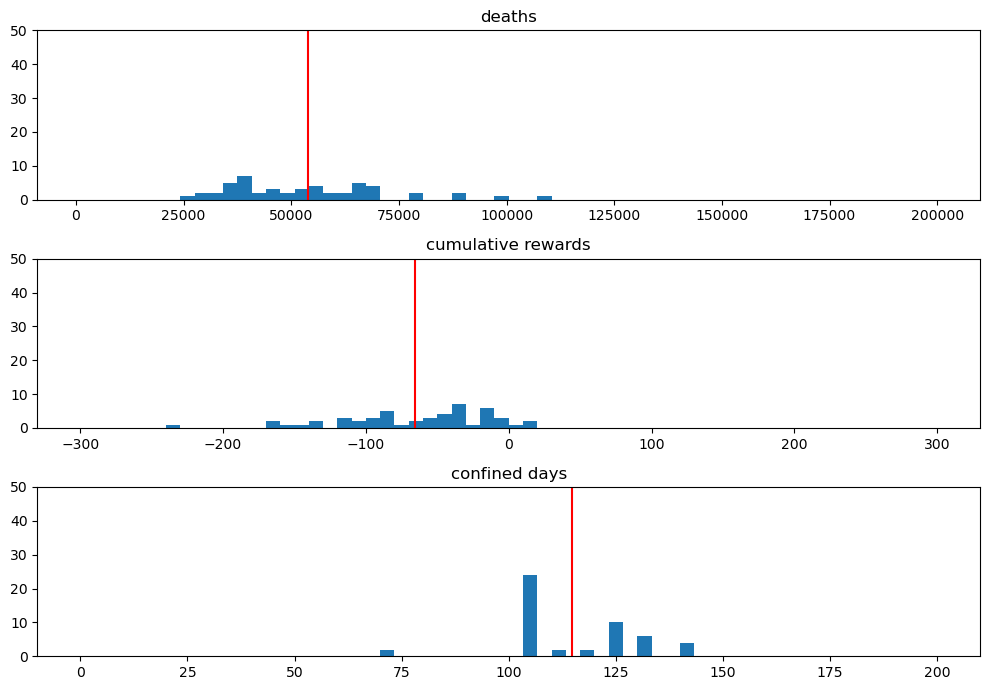

Average death number: 53764.5
Average number of confined days: 114.8
Average cumulative reward: -65.6389829381532


In [12]:
plot_histograms(deaths, rewards, conf_days)

## Prerequisites and needed data structures for the following tasks

### Memory Buffer

In [13]:
# The following is a named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# The following is a cyclic buffer of bounded size that holds the transitions observed recently. 
# It also implements a .sample() method for selecting a random batch of transitions for training.
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Deep Q-Learning Network (DQN)

In [14]:
class DQN(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super().__init__()
        
        # MLP network
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_observations, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),  
            torch.nn.Linear(16, n_actions)
        )
        
    # Called in order to compute the forward pass in the network
    def forward(self, x):
        new_x = torch.flatten(x,1) ** (1/4) # since we might end up having very small input values due to the scaling
                                            # We flatten the input in order to use it in the linear network
        
        return self.mlp(new_x)

### Setting useful parameters

In [15]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
BATCH_SIZE = 2048
# GAMMA is the discount factor
GAMMA = 0.9
# EPS_START is the starting value of epsilon
EPS_START = 0.7
# EPS_END is the final value of epsilon (in case of decaying epsilon,meant to reduce the exploration)
EPS_MIN = 0.2 # same as EPS_START since we do not want to decrease it
# DECREASE_FLAG indicates whether we want to decrease the exploration
DECREASE_FLAG = False
# EXPLORATION_FLAG indicates whether we want to explore or not
EXPLORATION_FLAG = True
# LR is the learning rate of the AdamW optimizer
LR = 5e-3

### Defining `select_action` function to reproduce the sampling of eps-greedy policy

In [16]:
# The following function defines the policy deployed in order to explore and interact with the environments.
# In particular, it is an epsilon greedy policy based on the values provided by the network trained up to 
# this moment

def select_action(state, decrease_flag, exploration_flag, curr_episode):
    sample = random.random()

    num_episodes = 500
    
    # Setting the epsilon parameter to have or avoid exploration
    if exploration_flag:
        if decrease_flag:
            eps_threshold = max(EPS_START*(num_episodes-curr_episode)/num_episodes, EPS_MIN)
        else:
            eps_threshold = EPS_START
    else:
        eps_threshold = 0 # in this case we only consider the greedy policy determined by the network
        
    if sample > eps_threshold:
        with torch.no_grad():
            # We use torch.no_grad() since we are now using the network to simply take an action.
            # We do not need to expand the DAG.
            # We only consider the larger value to take the action.
            return policy_net(state).max(1)[1].view(1,1) # this format is needed to concatenate
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

#### Defining `optimize_model` function to update the weights of the network

In [17]:
def optimize_model():
    
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements, moving the final results to the device
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    
    # We save the non final state in our sampling
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # We save and concatenate the variables we need
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch)
    state_action_values = state_action_values.gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # we compute max_a Q(s', a) in order to quantify the delta. We use the target net to improve stability
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

## Question 3

### Question 3.a

We start by defining action preprocessors and observation preprocessor to convert data from environment and neural network.

In [18]:
# Action Preprocessor: the deafult action (Do Nothing) is encoded as 0, the CONFINEMENT action is encoded as 1

ACTION_NULL = 0
ACTION_CONFINE = 1

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False}
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
        
    return action

# Observation Preprocessor: every observation is converted to a tensor containing the proportion of death and
# infected people in each city

# Since the observation space contains the measurement of the proportion of dead and infected people in each city
# we naively scale the observation space with SCALE = 1
SCALE = 1
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

We import useful packages, we initialize the environments making sure to define the appropriate observation and action spaces. This is essential, since the action and observation format needed by the dynamic model is different from the encoding taken as input by the neural network we are going to train.

In [19]:
# Initializing the environment
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.Discrete(2) , # Here one could pass an openai gym action space that can then be sampled
            observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

We now initiliaze the models we need and other additional useful variables that will be used in the training and evaluation procedure.

In [20]:
# Get number of actions from gym action space
n_actions = env.action_space.n

# Get the number of state observations
obs, info = env.reset() # we should set the seed
n_observations = 2*9*7

policy_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to train
target_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to keep fixed for some iterates
target_net.load_state_dict(policy_net.state_dict())    # we initialize it as a copy of the policy net

optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True) # we initialize the optimizer
memory = ReplayMemory(20000) # we initialize the buffer from which we sample already observed transitions

In [21]:
num_episodes = 500
num_eval_episodes = 20
num_weeks = 30

# training seeds
training_seeds = np.random.randint(22, 10000, size=1500)

# evaluation seeds
eval_seeds = np.arange(1, 21)

training = []
training_weights = []
evaluation = []

makedirs('./checkpoints_task3a', exist_ok=True)
rmtree('./checkpoints_task3a')
makedirs('./checkpoints_task3a')
PATH = './checkpoints_task3a/policy_net'

for training_process in range(3):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process+1))
    
    torch.manual_seed(training_process)
    torch.use_deterministic_algorithms(True)
    
    policy_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to train
    target_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to keep fixed for some iterates
    target_net.load_state_dict(policy_net.state_dict())    # we initialize it as a copy of the policy net
    optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(20000) # we initialize the buffer from which we sample already observed transitions
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []

    for i_episode in range(num_episodes):
        
        if (i_episode % 10) == 0:
            print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*training_process + i_episode])
        state = torch.tensor(state, device=device)

        # We run an episode
        for t in range(num_weeks):

            action = select_action(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            obs, reward, done, info = env.step(action.item())

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)

            # Store the transition in memory (in the replay buffer)
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)

        # We run a training step on policy_net
        optimize_model()

        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes
            policy_net_state_dict = policy_net.state_dict()
            target_net.load_state_dict(policy_net_state_dict)

        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)

                for new_week in range(num_weeks):

                    action = select_action(state, DECREASE_FLAG, False, new_episode) # greedy policy when eploration_flag = False
                    obs, reward, done, info = env.step(action.item())
                    total_eval_reward += reward.item()

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)

                    # Move to the next state
                    state = next_state

                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
            
    torch.save(policy_net.state_dict(), PATH + str(training_process) + '.pt')
    training.append(training_trace)
    training_weights.append(policy_net_state_dict)
    evaluation.append(eval_trace)

print('Complete')


 TRAINING PROCESS :1 

Training episode :0
Training episode :10
Training episode :20
Training episode :30
Training episode :40
Evaluation cycle: 1
Training episode :50
Training episode :60
Training episode :70
Training episode :80
Training episode :90
Evaluation cycle: 2
Training episode :100
Training episode :110
Training episode :120
Training episode :130
Training episode :140
Evaluation cycle: 3
Training episode :150
Training episode :160
Training episode :170
Training episode :180
Training episode :190
Evaluation cycle: 4
Training episode :200
Training episode :210
Training episode :220
Training episode :230
Training episode :240
Evaluation cycle: 5
Training episode :250
Training episode :260
Training episode :270
Training episode :280
Training episode :290
Evaluation cycle: 6
Training episode :300
Training episode :310
Training episode :320
Training episode :330
Training episode :340
Evaluation cycle: 7
Training episode :350
Training episode :360
Training episode :370
Training ep

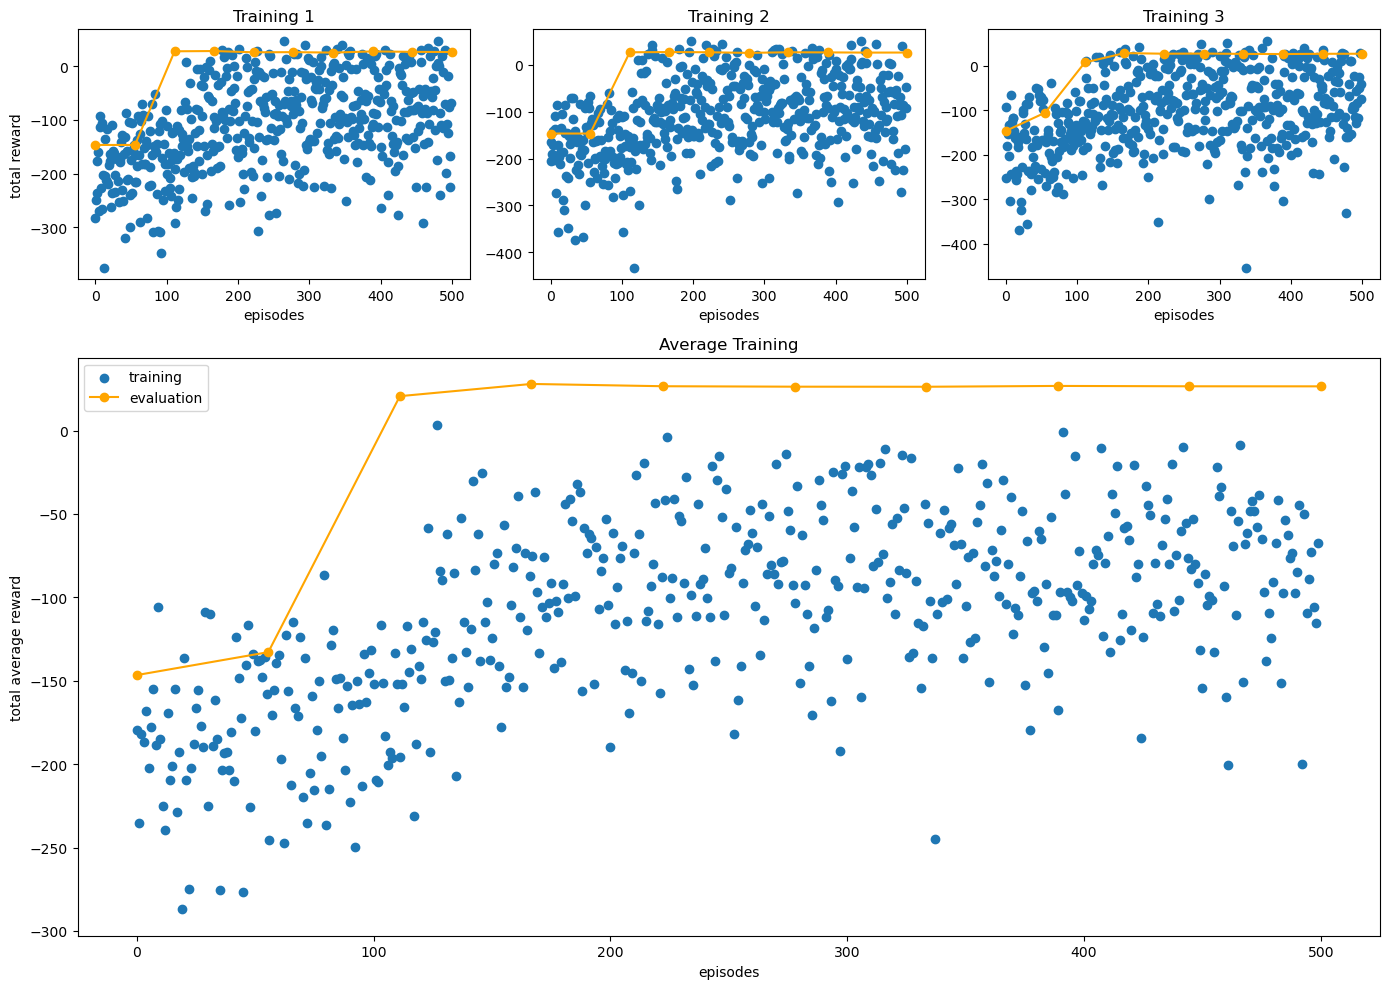

In [52]:
plot_training_eval(training, evaluation)

### Loading the final best model

In [55]:
final_performance = np.array([evaluation[0][-1], evaluation[1][-1], evaluation[2][-1]])
best_model_idx = np.argmax(final_performance)

best_file = torch.load(PATH + str(best_model_idx) + '.pt')
best_mod = DQN(n_observations, n_actions).to(device)
best_mod.load_state_dict(best_file)

print(best_mod.state_dict())

2
OrderedDict([('mlp.0.weight', tensor([[ 0.0603,  0.1023,  0.1159,  ...,  0.0640,  0.1140,  0.0540],
        [ 0.1007,  0.1443,  0.0165,  ..., -0.0033, -0.0343, -0.0074],
        [ 0.1392, -0.0154, -0.0014,  ...,  0.1843,  0.0623,  0.0485],
        ...,
        [-0.0922, -0.0500, -0.0342,  ..., -0.0052,  0.0303, -0.0635],
        [-0.0395,  0.0295, -0.0511,  ..., -0.0923, -0.0234, -0.1014],
        [ 0.1999,  0.1069,  0.1231,  ...,  0.1106,  0.1590,  0.0242]],
       device='mps:0')), ('mlp.0.bias', tensor([ 0.1376,  0.1447,  0.2108, -0.0992,  0.1629, -0.0652,  0.3057, -0.0330,
         0.3330, -0.1189,  0.8431,  0.4433,  0.1240, -0.1111,  0.0732,  0.0921,
         0.3584,  0.1058, -0.0656,  0.0980,  0.1917,  0.2746, -0.0993,  0.1652,
         0.0723,  0.1349,  0.1844,  0.4509,  0.4983,  0.1687,  0.1786,  0.1877,
        -0.0978, -0.0311, -0.0733,  0.3121,  0.6583,  0.2345, -0.0226,  0.1526,
         0.2245,  0.4246,  0.0353,  0.1892,  0.2357,  0.4373,  0.6545,  0.1869,
         0.343

#### Question 3.b

In [ ]:
# DECREASE_FLAG indicates whether we want to decrease the exploration
DECREASE_FLAG = True

Now we can implement a different exploration policy by adjusting some parameters. 

In particular, we want to implement a decrease in the exploration threshold.
This is done to advantage exploration over exploitation in the first stage of the training process, in order to speed up the learning process. The deeper we go in the training, the more information we have about the environment and the transitions, therefore we decrease the exploration coefficient in order to take advantage of exploitation. 

In [ ]:
# EPS_START is the starting value of epsilon
EPS_START = 0.7
# EPS_END is the final value of epsilon (in case of decaying epsilon, meant to reduce the exploration)
EPS_MIN = 0.2
# DECREASE_FLAG indicates whether we want to decrease the exploration
DECREASE_FLAG = True
# EXPLORATION_FLAG indicates whether we want to explore or not
EXPLORATION_FLAG = 1

In [ ]:
# The following function defines the policy deployed in order to explore and interact with the environments.
# In particular, it is an epsilon greedy policy based on the values provided by the network trained up to 
# this moment

def select_action(state, decrease_flag, exploration_flag, curr_episode):
    sample = random.random()
    
    # Setting the epsilon parameter to have or avoid exploration
    if exploration_flag:
        if decrease_flag:
            eps_threshold = max(EPS_START*(num_episodes-curr_episode)/num_episodes, EPS_MIN)
        else:
            eps_threshold = EPS_START
    else:
        eps_threshold = 0 # in this case we only consider the greedy policy determined by the network
        
    if sample > eps_threshold:
        with torch.no_grad():
            # We use torch.no_grad() since we are now using the network to simply take an action.
            # We do not need to expand the DAG.
            # We only consider the larger value to take the action.
            return policy_net(state).max(1)[1].view(1,1) # this format is needed to concatenate
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [ ]:
num_episodes = 50
num_eval_episodes = 20
num_weeks = 30
training_seeds = range(1,num_episodes + 1)
eval_seeds = range(num_episodes + 1, num_episodes + num_eval_episodes + 1)

# Initialize list to keep trace of log rewards
training_trace = []
eval_trace = []

for i_episode in range(num_episodes):
    
    print('Training episode :{}'.format(i_episode))
    # Initialize variable to keep trace of the total reward
    total_training_reward = 0
    # Initialize the environment and get its state (moving it to the device)
    state, info = env.reset(training_seeds[i_episode])
    state = torch.tensor(state, device=device)
    
    # We run an episode
    for t in range(num_weeks):
        
        action = select_action(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
        obs, reward, done, info = env.step(action.item())
        
        total_training_reward += reward.item()
        reward = torch.tensor([reward], device=device)
        
        if done: # in our case it corresponds to 30 weeks
            next_state = None
        else:
            next_state = torch.tensor(obs, device=device)

        # Store the transition in memory (in the replay buffer)
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        if done:
            break

    # We log the cumulative reward to training trace
    training_trace.append(total_training_reward)
            
    # We run a training step on policy_net
    optimize_model()
    
    if ((i_episode + 1) % 5 == 0):

        # We update the target network every 5 epsiodes
        policy_net_state_dict = policy_net.state_dict()
        target_net.load_state_dict(policy_net_state_dict)
    
    if ((i_episode + 1) % 50 == 0) or ((i_episode +1) == 500):
        
        average_rewards = []
        
        for new_episode in range(num_eval_episodes):
            
            total_eval_reward = 0
            state, info = env.reset(eval_seeds[new_episode])
            state = torch.tensor(state, device=device)
            
            for new_week in range(num_weeks):
                
                action = select_action(state, DECREASE_FLAG, 0, new_episode) # greedy policy when eploration_flag = 0
                obs, reward, done, info = env.step(action.item())
                total_eval_reward += reward.item()
                
                if done: # in our case it corresponds to 30 weeks
                    next_state = None
                else:
                    next_state = torch.tensor(obs, device=device)
                
                # Move to the next state
                state = next_state
                
                if done:
                    break
            
            average_rewards.append(total_eval_reward)
        
        eval_trace.append(np.mean(average_rewards))

print('Complete')

In [ ]:
plt.scatter(np.arange(len(training_trace)), training_trace, label='training')
plt.scatter(np.arange(len(eval_trace)), eval_trace, label='training')
plt.legend()
plt.ylabel('total reward trace')
plt.xlabel('episodes')
plt.title('Training and Evaluation Traces')
plt.show()

## Question 4.1

Setting the parameters

In [ ]:
DECRESE_FLAG = True
LR = 10e-5

### Question 4.a

con 5 neuroni in più nell'input (embedding dell'azione alla settimana prima) ci fa risparmiare 2^5 neuroni in uscita
in uscita abbiamo quindi 5 neuroni invece che 2^5

nel caso tabular con (stato agnostico alla situazione attuale sulle azioni), in output dovremmo quindi avere 2^5 neuroni, il che vorrebbe dire che potenzialmente potremmo prendere più 'toggle' contemporaneamente, che non è possibile

dando informazioni sull'azione in input, invece, possiamo ridurre l'output a 5 neuroni e poi applicare una softmax per scegliere quale toggle applicare
In questo modo imponiamo che possa essere switchata solo una azione alla volta

In [ ]:
# Action Preprocessor: the deafult action (Do Nothing) is encoded as 0, the CONFINEMENT action is encoded as 1

TOGGLE_NULL = 0
TOGGLE_CONFINEMENT = 1
TOGGLE_ISOLATION = 2
TOGGLE_HOSPITAL = 3
TOGGLE_VACCINATION = 4

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    
    default_action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False}
    
    if a not in range(0, 5):
        print('Not a valid action!')
        return default_action
    
    
    action = dyn.get_action()
    
    if a == TOGGLE_NULL: 
        return action
    elif a == TOGGLE_CONFINEMENT:
        action['confinement'] = not action['confinement'] 
    elif a == TOGGLE_ISOLATION:
        action['isolation'] = not action['isolation']
    elif a == TOGGLE_HOSPITAL:
        action['hospital'] = not action['hospital']
    else: 
        action['vaccinate'] = not action['vaccinate']
    
    return action

# Observation Preprocessor: every observation is converted to a tensor containing the proportion of death and
# infected people in each city

SCALE = 1
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    
    curr_action = torch.Tensor(4)
    curr_action[0] = 1 if dyn.get_action()['confinement'] else 0
    curr_action[1] = 1 if dyn.get_action()['isolation'] else 0
    curr_action[2] = 1 if dyn.get_action()['hospital'] else 0
    curr_action[3] = 1 if dyn.get_action()['vaccinate'] else 0
    
    ret = torch.flatten(torch.Tensor(np.stack((infected, dead))).unsqueeze(0),1)
    ret = torch.cat([ret, curr_action.unsqueeze(dim=0)], dim=1)
    
    return ret

In [ ]:
# Loading the environment that allows us to observe the duìynamics of the pandemic all over Switzerland
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

# Initializing the environment
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.Discrete(5) , # Here one could pass an openai gym action space that can then be sampled
            # observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

# If gpu is to be used
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
# The following is a named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# The following is a cyclic buffer of bounded size that holds the transitions observed recently. 
# It also implements a .sample() method for selecting a random batch of transitions for training.
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super().__init__()
        
        # MLP network
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_observations, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),  
            torch.nn.Linear(16, n_actions)
        )
        
    # Called in order to compute the forward pass in the network
    def forward(self, x):
        new_x = torch.flatten(x,1) ** (1/4) # since we might end up having very small input values due to the scaling
                                            # We flatten the input in order to use it in the linear network
        
        return self.mlp(new_x)

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
BATCH_SIZE = 10
# GAMMA is the discount factor
GAMMA = 0.9
# EPS_START is the starting value of epsilon
EPS_START = 0.7
# EPS_END is the final value of epsilon (in case of decaying epsilon,meant to reduce the exploration)
EPS_MIN = 0.2 # same as EPS_START since we do not want to decrease it
# DECREASE_FLAG indicates whether we want to decrease the exploration
DECREASE_FLAG = False
# EXPLORATION_FLAG indicates whether we want to explore or not
EXPLORATION_FLAG = True
# LR is the learning rate of the AdamW optimizer
LR = 5e-3

# Get number of actions from gym action space
n_actions = env.action_space.n

# Get the number of state observations
obs, info = env.reset() # we should set the seed
n_observations = 130

In [ ]:
# The following function defines the policy deployed in order to explore and interact with the environments.
# In particular, it is an epsilon greedy policy based on the values provided by the network trained up to 
# this moment

def select_action(state, decrease_flag, exploration_flag, curr_episode):
    sample = random.random()
    
    # Setting the epsilon parameter to have or avoid exploration
    if exploration_flag:
        if decrease_flag:
            eps_threshold = max(EPS_START*(num_episodes-curr_episode)/num_episodes, EPS_MIN)
        else:
            eps_threshold = EPS_START
    else:
        eps_threshold = 0 # in this case we only consider the greedy policy determined by the network
        
    if sample > eps_threshold:
        with torch.no_grad():
            # We use torch.no_grad() since we are now using the network to simply take an action.
            # We do not need to expand the DAG.
            # We only consider the larger value to take the action.
            return policy_net(state).max(1)[1].view(1,1) # this format is needed to concatenate
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [37]:
def optimize_model():
    
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements, moving the final results to the device
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    
    # We save the non final state in our sampling
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # We save and concatenate the variables we need
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch)
    state_action_values = state_action_values.gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # we compute max_a Q(s', a) in order to quantify the delta. We use the target net to improve stability
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [38]:
num_episodes = 110
num_eval_episodes = 20
num_weeks = 30
training_seeds = range(1, num_episodes + 1)
eval_seeds = range(num_episodes + 1, num_episodes + num_eval_episodes + 1)

training = []
training_weights = []
evaluation = []

makedirs('./checkpoints_task4', exist_ok=True)
rmtree('./checkpoints_task4')
makedirs('./checkpoints_task4')
PATH = './checkpoints_task4/policy_net'

for training_process in range(1, 2):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process))
    
    policy_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to train
    target_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to keep fixed for some iterates
    target_net.load_state_dict(policy_net.state_dict())    # we initialize it as a copy of the policy net
    
    optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True) # we initialize the optimizer
    
    memory = ReplayMemory(20000) # we initialize the buffer from which we sample already observed transitions
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []

    for i_episode in range(num_episodes):
        
        if (i_episode % 10) == 0:
            print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*(training_process-1) + i_episode])
        
        state = torch.tensor(state, device=device)
        
        # We run an episode
        for t in range(num_weeks):

            action = select_action(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            obs, reward, done, info = env.step(action.item())
            
            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)
                
            # Store the transition in memory (in the replay buffer)
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state
            
            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)

        # We run a training step on policy_net
        optimize_model()

        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes
            policy_net_state_dict = policy_net.state_dict()
            target_net.load_state_dict(policy_net_state_dict)

        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)
                
                for new_week in range(num_weeks):

                    action = select_action(state, DECREASE_FLAG, False, new_episode)
                    obs, reward, done, info = env.step(action.item())

                    total_training_reward += reward.item()
                    reward = torch.tensor([reward], device=device)

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)
                        
                    # Move to the next state
                    state = next_state
                    
                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
            
    torch.save(policy_net.state_dict(), PATH + str(training_process) + '.pt')
    training.append(training_trace)
    training_weights.append(policy_net_state_dict)
    evaluation.append(eval_trace)

print('Complete')


 TRAINING PROCESS :1 

Training episode :0
Training episode :10
Training episode :20
Training episode :30
Training episode :40
Evaluation cycle: 1
Training episode :50
Training episode :60
Training episode :70
Training episode :80
Training episode :90
Evaluation cycle: 2
Training episode :100
Complete


In [ ]:
good_file = torch.load(PATH + str(training_process) + '.pt')
good_mod = DQN(n_observations, n_actions).to(device)
good_mod.load_state_dict(good_file)

print(good_mod.state_dict())

#### Question 4.1.d

la distanza (in termini di metrica) fra un'azione e la successiva deve essere al più 1
ossia possiamo fare il toggling solo di una azione alla volta (al massimo... volendo si può anche non cambiare nulla)

In [25]:
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False}
    
    action['confinement'] = bool(a[0])
    action['isolation'] = bool(a[1])
    action['hospital'] = bool(a[2])
    action['vaccinate'] = bool(a[3])
    
    return action

# Observation Preprocessor: every observation is converted to a tensor containing the proportion of death and
# infected people in each city

SCALE = 1
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [26]:
# Loading the environment that allows us to observe the duìynamics of the pandemic all over Switzerland
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

# Initializing the environment
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.MultiBinary([4,2]) , # Here one could pass an openai gym action space that can then be sampled
            observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

# If gpu is to beused
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [27]:
# The following is a named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# The following is a cyclic buffer of bounded size that holds the transitions observed recently. 
# It also implements a .sample() method for selecting a random batch of transitions for training.
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [28]:
class DQN(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super().__init__()
        
        # MLP network
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_observations, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),  
            torch.nn.Linear(16, n_actions)
        )
        
    # Called in order to compute the forward pass in the network
    def forward(self, x):
        new_x = torch.flatten(x,1) ** (1/4) # since we might end up having very small input values due to the scaling
                                            # We flatten the input in order to use it in the linear network
        z = self.mlp(new_x)
        
        return torch.reshape(z, (-1,4,2))

In [29]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
BATCH_SIZE = 10
# GAMMA is the discount factor
GAMMA = 0.9
# EPS_START is the starting value of epsilon
EPS_START = 0.7
# EPS_END is the final value of epsilon (in case of decaying epsilon,meant to reduce the exploration)
EPS_MIN = 0.2 # same as EPS_START since we do not want to decrease it
# DECREASE_FLAG indicates whether we want to decrease the exploration
DECREASE_FLAG = False
# EXPLORATION_FLAG indicates whether we want to explore or not
EXPLORATION_FLAG = True
# LR is the learning rate of the AdamW optimizer
LR = 5e-3

# Get number of actions from gym action space
n_actions = env.action_space.n[0] * env.action_space.n[1]

# Get the number of state observations
obs, info = env.reset() # we should set the seed
n_observations = 2*7*9

In [41]:
# The following function defines the policy deployed in order to explore and interact with the environments.
# In particular, it is an epsilon greedy policy based on the values provided by the network trained up to 
# this moment

def select_action(state, decrease_flag, exploration_flag, curr_episode):
    sample = random.random()
    
    # Setting the epsilon parameter to have or avoid exploration
    if exploration_flag:
        if decrease_flag:
            eps_threshold = max(EPS_START*(num_episodes-curr_episode)/num_episodes, EPS_MIN)
        else:
            eps_threshold = EPS_START
    else:
        eps_threshold = 0 # in this case we only consider the greedy policy determined by the network
        
    if sample > eps_threshold:
        with torch.no_grad():
            # We use torch.no_grad() since we are now using the network to simply take an action.
            # We do not need to expand the DAG.
            # We only consider the larger value to take the action.
            return policy_net(state).max(2)[1]
            
    else:
        return torch.tensor([env.action_space.sample()], device=device, dtype=torch.long).max(2)[1]

In [43]:
state1 = env.observation_space.sample()
state1 = torch.tensor(state1, device=device).unsqueeze(0)
state2 = env.observation_space.sample()
state2 = torch.tensor(state2, device=device).unsqueeze(0)
obs = torch.cat([state1, state2], dim=0)
policy_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to train
print(policy_net(obs))
print(policy_net(obs).max(2)[1].shape)

tensor([[[-0.1813, -0.0794],
         [ 0.0028,  0.0219],
         [-0.1632, -0.1173],
         [-0.0072,  0.1898]],

        [[-0.1821, -0.0879],
         [ 0.0028,  0.0140],
         [-0.1656, -0.1177],
         [-0.0123,  0.1902]]], device='mps:0', grad_fn=<ViewBackward0>)
torch.Size([2, 4])


In [88]:
def optimize_model():
    
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements, moving the final results to the device
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    
    # We save the non final state in our sampling
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # We save and concatenate the variables we need
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch)
    state_action_values = torch.sum(state_action_values.gather(2, action_batch.unsqueeze(2)), dim=1)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # we compute max_a Q(s', a) in order to quantify the delta. We use the target net to improve stability
        next_state_values[non_final_mask] = torch.sum(target_net(non_final_next_states).max(2)[0], dim=1)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [87]:
a = torch.rand((2,4,2))
a.gather(2, target_net(non_final_next_states), (2,4,1)))
print(a, a.shape)
print(a.gather(2, torch.reshape(torch.tensor([0,0,1,0,0,0,0,0]), (2,4,1))))
print(torch.sum(a.gather(2, target_net(non_final_next_states), (2,4,1))), dim=1))

tensor([[[7.1734e-03, 1.3024e-01],
         [3.1987e-01, 3.2919e-01],
         [8.6009e-01, 3.5246e-01],
         [2.0376e-01, 7.6060e-01]],

        [[1.2841e-01, 7.0874e-01],
         [2.7325e-01, 7.0381e-04],
         [1.2260e-01, 9.1810e-01],
         [2.6274e-01, 2.2782e-01]]]) torch.Size([2, 4, 2])
tensor([[[0.0072],
         [0.3199],
         [0.3525],
         [0.2038]],

        [[0.1284],
         [0.2733],
         [0.1226],
         [0.2627]]])
tensor([[0.8833],
        [0.7870]])


In [89]:
num_episodes = 110
num_eval_episodes = 20
num_weeks = 30
training_seeds = range(1, num_episodes + 1)
eval_seeds = range(num_episodes + 1, num_episodes + num_eval_episodes + 1)

training = []
training_weights = []
evaluation = []

makedirs('./checkpoints_task4', exist_ok=True)
rmtree('./checkpoints_task4')
makedirs('./checkpoints_task4')
PATH = './checkpoints_task4/policy_net'

for training_process in range(1, 2):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process))
    
    policy_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to train
    target_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to keep fixed for some iterates
    target_net.load_state_dict(policy_net.state_dict())    # we initialize it as a copy of the policy net
    
    optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True) # we initialize the optimizer
    
    memory = ReplayMemory(20000) # we initialize the buffer from which we sample already observed transitions
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []

    for i_episode in range(num_episodes):
        
        if (i_episode % 10) == 0:
            print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*(training_process-1) + i_episode])
        
        state = torch.tensor(state, device=device)
        
        # We run an episode
        for t in range(num_weeks):

            action = select_action(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            obs, reward, done, info = env.step(action.squeeze())

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)
                
            # Store the transition in memory (in the replay buffer)
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state
            
            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)

        # We run a training step on policy_net
        optimize_model()

        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes
            policy_net_state_dict = policy_net.state_dict()
            target_net.load_state_dict(policy_net_state_dict)

        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)
                
                for new_week in range(num_weeks):

                    action = select_action(state, DECREASE_FLAG, False, new_episode)
                    obs, reward, done, info = env.step(action)

                    total_training_reward += reward.item()
                    reward = torch.tensor([reward], device=device)

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)
                        
                    # Move to the next state
                    state = next_state
                    
                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
            
    torch.save(policy_net.state_dict(), PATH + str(training_process) + '.pt')
    training.append(training_trace)
    training_weights.append(policy_net_state_dict)
    evaluation.append(eval_trace)

print('Complete')


 TRAINING PROCESS :1 

Training episode :0
Training episode :10
Training episode :20


KeyboardInterrupt: 